# Method 2 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

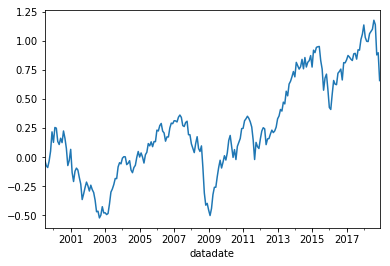

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.218017
2000-12-31   -0.201410
2001-12-31   -0.191172
2002-12-31   -0.336672
2003-12-31    0.807583
2004-12-31    0.112428
2005-12-31    0.080476
2006-12-31    0.136295
2007-12-31   -0.074009
2008-12-31   -0.494055
2009-12-31    0.678755
2010-12-31    0.229544
2011-12-31   -0.137208
2012-12-31    0.171199
2013-12-31    0.378930
2014-12-31    0.078735
2015-12-31   -0.155717
2016-12-31    0.145236
2017-12-31    0.135828
2018-12-31   -0.193690
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     685.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.92e-126
Time:                        00:34:53   Log-Likelihood:                 601.07
No. Observations:                 234   AIC:                            -1192.
Df Residuals:                     229   BIC:                            -1175.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.661      0.509      -0.003       0.002
mktrf          1.2078      0.035     34.546      0.000       1.139       1.277
me             0.4028      0.041      9.905      0.000       0.323       0.483
ia             0.0220      0.062      0.356      0.722      -0.100       0.144
roe           -0.3214      0.053     -6.075      0.000      -0.426      -0.217
==============================================================================
Omnibus:                       10.627   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               19.221
Skew:                          -0.195   Prob(JB):                     6.70e-05
Kurtosis:                       4.349   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     497.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.22e-111
Time:                        00:34:53   Log-Likelihood:                 601.07
No. Observations:                 234   AIC:                            -1192.
Df Residuals:                     229   BIC:                            -1175.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.658      0.511      -0.003       0.002
mktrf          1.2078      0.050     24.264      0.000       1.110       1.305
me             0.4028      0.077      5.221      0.000       0.252       0.554
ia             0.0220      0.089      0.247      0.805      -0.152       0.196
roe           -0.3214      0.083     -3.855      0.000      -0.485      -0.158
==============================================================================
Omnibus:                       10.627   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               19.221
Skew:                          -0.195   Prob(JB):                     6.70e-05
Kurtosis:                       4.349   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     857.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.63e-136
Time:                        00:34:53   Log-Likelihood:                 601.07
No. Observations:                 234   AIC:                            -1192.
Df Residuals:                     229   BIC:                            -1175.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.676      0.499      -0.003       0.002
mktrf          1.2078      0.053     22.925      0.000       1.105       1.311
me             0.4028      0.083      4.851      0.000       0.240       0.566
ia             0.0220      0.084      0.262      0.794      -0.143       0.187
roe           -0.3214      0.089     -3.612      0.000      -0.496      -0.147
==============================================================================
Omnibus:                       10.627   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               19.221
Skew:                          -0.195   Prob(JB):                     6.70e-05
Kurtosis:                       4.349   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     480.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.59e-119
Time:                        00:34:53   Log-Likelihood:                 587.25
No. Observations:                 234   AIC:                            -1163.
Df Residuals:                     228   BIC:                            -1142.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.911      0.363      -0.004       0.001
mktrf          1.2372      0.037     33.220      0.000       1.164       1.311
smb            0.4596      0.049      9.352      0.000       0.363       0.556
hml            0.1169      0.058      2.018      0.045       0.003       0.231
rmw           -0.2592      0.066     -3.956      0.000      -0.388      -0.130
cma           -0.0558      0.083     -0.670      0.503      -0.220       0.108
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               16.928
Skew:                           0.012   Prob(JB):                     0.000211
Kurtosis:                       4.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     458.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.73e-117
Time:                        00:34:53   Log-Likelihood:                 587.25
No. Observations:                 234   AIC:                            -1163.
Df Residuals:                     228   BIC:                            -1142.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -0.856      0.392      -0.004       0.002
mktrf          1.2372      0.041     29.828      0.000       1.156       1.318
smb            0.4596      0.067      6.872      0.000       0.329       0.591
hml            0.1169      0.101      1.157      0.247      -0.081       0.315
rmw           -0.2592      0.099     -2.618      0.009      -0.453      -0.065
cma           -0.0558      0.107     -0.522      0.601      -0.265       0.154
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               16.928
Skew:                           0.012   Prob(JB):                     0.000211
Kurtosis:                       4.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     772.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.27e-141
Time:                        00:34:53   Log-Likelihood:                 587.25
No. Observations:                 234   AIC:                            -1163.
Df Residuals:                     228   BIC:                            -1142.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.816      0.414      -0.004       0.002
mktrf          1.2372      0.040     30.943      0.000       1.159       1.316
smb            0.4596      0.069      6.627      0.000       0.324       0.595
hml            0.1169      0.090      1.294      0.196      -0.060       0.294
rmw           -0.2592      0.103     -2.527      0.011      -0.460      -0.058
cma           -0.0558      0.112     -0.496      0.620      -0.276       0.165
==============================================================================
Omnibus:                        8.825   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               16.928
Skew:                           0.012   Prob(JB):                     0.000211
Kurtosis:                       4.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     643.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.78e-123
Time:                        00:34:53   Log-Likelihood:                 594.36
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     229   BIC:                            -1161.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.285      0.200      -0.004       0.001
mktrf          1.2312      0.033     37.169      0.000       1.166       1.296
smb            0.5726      0.041     13.848      0.000       0.491       0.654
hml            0.0703      0.041      1.712      0.088      -0.011       0.151
umd           -0.1657      0.027     -6.148      0.000      -0.219      -0.113
==============================================================================
Omnibus:                        5.802   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.646
Skew:                           0.148   Prob(JB):                       0.0219
Kurtosis:                       3.834   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     636.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.02e-122
Time:                        00:34:53   Log-Likelihood:                 594.36
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     229   BIC:                            -1161.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.271      0.204      -0.004       0.001
mktrf          1.2312      0.042     29.513      0.000       1.149       1.313
smb            0.5726      0.068      8.461      0.000       0.440       0.705
hml            0.0703      0.057      1.228      0.219      -0.042       0.183
umd           -0.1657      0.040     -4.174      0.000      -0.243      -0.088
==============================================================================
Omnibus:                        5.802   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.646
Skew:                           0.148   Prob(JB):                       0.0219
Kurtosis:                       3.834   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     786.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.68e-132
Time:                        00:34:53   Log-Likelihood:                 594.36
No. Observations:                 234   AIC:                            -1179.
Df Residuals:                     229   BIC:                            -1161.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.285      0.199      -0.004       0.001
mktrf          1.2312      0.040     31.012      0.000       1.153       1.309
smb            0.5726      0.076      7.533      0.000       0.424       0.722
hml            0.0703      0.053      1.318      0.187      -0.034       0.175
umd           -0.1657      0.036     -4.632      0.000      -0.236      -0.096
==============================================================================
Omnibus:                        5.802   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.646
Skew:                           0.148   Prob(JB):                       0.0219
Kurtosis:                       3.834   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     341.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.14e-63
Time:                        00:34:53   Log-Likelihood:                 291.40
No. Observations:                 120   AIC:                            -572.8
Df Residuals:                     115   BIC:                            -558.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.767      0.444      -0.003       0.006
mktrf          1.2769      0.056     22.727      0.000       1.166       1.388
me             0.3630      0.055      6.542      0.000       0.253       0.473
ia            -0.0235      0.087     -0.271      0.787      -0.196       0.149
roe           -0.2323      0.077     -3.020      0.003      -0.385      -0.080
==============================================================================
Omnibus:                        4.854   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.952
Skew:                          -0.282   Prob(JB):                       0.0841
Kurtosis:                       3.819   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     257.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.23e-56
Time:                        00:34:53   Log-Likelihood:                 291.40
No. Observations:                 120   AIC:                            -572.8
Df Residuals:                     115   BIC:                            -558.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.743      0.457      -0.003       0.006
mktrf          1.2769      0.064     19.896      0.000       1.151       1.403
me             0.3630      0.082      4.421      0.000       0.202       0.524
ia            -0.0235      0.112     -0.210      0.834      -0.243       0.196
roe           -0.2323      0.095     -2.451      0.014      -0.418      -0.047
==============================================================================
Omnibus:                        4.854   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.952
Skew:                          -0.282   Prob(JB):                       0.0841
Kurtosis:                       3.819   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     487.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.40e-71
Time:                        00:34:53   Log-Likelihood:                 291.40
No. Observations:                 120   AIC:                            -572.8
Df Residuals:                     115   BIC:                            -558.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.858      0.391      -0.002       0.005
mktrf          1.2769      0.064     20.105      0.000       1.152       1.401
me             0.3630      0.088      4.148      0.000       0.191       0.535
ia            -0.0235      0.105     -0.224      0.823      -0.230       0.183
roe           -0.2323      0.090     -2.572      0.010      -0.409      -0.055
==============================================================================
Omnibus:                        4.854   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.952
Skew:                          -0.282   Prob(JB):                       0.0841
Kurtosis:                       3.819   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     257.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.49e-60
Time:                        00:34:53   Log-Likelihood:                 288.51
No. Observations:                 120   AIC:                            -565.0
Df Residuals:                     114   BIC:                            -548.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.980      0.329      -0.002       0.007
mktrf          1.3393      0.061     21.972      0.000       1.219       1.460
smb            0.4355      0.069      6.308      0.000       0.299       0.572
hml            0.0011      0.085      0.013      0.989      -0.166       0.169
rmw           -0.1503      0.100     -1.506      0.135      -0.348       0.047
cma           -0.0088      0.109     -0.081      0.936      -0.225       0.208
==============================================================================
Omnibus:                        4.061   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                4.542
Skew:                          -0.153   Prob(JB):                        0.103
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     274.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.54e-62
Time:                        00:34:53   Log-Likelihood:                 288.51
No. Observations:                 120   AIC:                            -565.0
Df Residuals:                     114   BIC:                            -548.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.059      0.290      -0.002       0.006
mktrf          1.3393      0.061     21.931      0.000       1.220       1.459
smb            0.4355      0.085      5.112      0.000       0.269       0.602
hml            0.0011      0.133      0.008      0.993      -0.261       0.263
rmw           -0.1503      0.133     -1.132      0.258      -0.410       0.110
cma           -0.0088      0.109     -0.081      0.935      -0.222       0.205
==============================================================================
Omnibus:                        4.061   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                4.542
Skew:                          -0.153   Prob(JB):                        0.103
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     533.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.74e-77
Time:                        00:34:53   Log-Likelihood:                 288.51
No. Observations:                 120   AIC:                            -565.0
Df Residuals:                     114   BIC:                            -548.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.230      0.219      -0.001       0.006
mktrf          1.3393      0.051     26.336      0.000       1.240       1.439
smb            0.4355      0.086      5.038      0.000       0.266       0.605
hml            0.0011      0.124      0.009      0.993      -0.242       0.245
rmw           -0.1503      0.142     -1.059      0.290      -0.428       0.128
cma           -0.0088      0.103     -0.086      0.931      -0.210       0.192
==============================================================================
Omnibus:                        4.061   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                4.542
Skew:                          -0.153   Prob(JB):                        0.103
Kurtosis:                       3.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     335.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.07e-62
Time:                        00:34:53   Log-Likelihood:                 290.42
No. Observations:                 120   AIC:                            -570.8
Df Residuals:                     115   BIC:                            -556.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.903      0.369      -0.002       0.006
mktrf          1.3120      0.050     26.293      0.000       1.213       1.411
smb            0.5065      0.057      8.915      0.000       0.394       0.619
hml            0.0142      0.057      0.249      0.804      -0.099       0.127
umd           -0.1244      0.035     -3.546      0.001      -0.194      -0.055
==============================================================================
Omnibus:                        3.208   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.840
Skew:                          -0.217   Prob(JB):                        0.242
Kurtosis:                       3.616   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     392.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.16e-66
Time:                        00:34:53   Log-Likelihood:                 290.42
No. Observations:                 120   AIC:                            -570.8
Df Residuals:                     115   BIC:                            -556.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.961      0.337      -0.002       0.006
mktrf          1.3120      0.051     25.607      0.000       1.212       1.412
smb            0.5065      0.081      6.289      0.000       0.349       0.664
hml            0.0142      0.073      0.194      0.846      -0.129       0.158
umd           -0.1244      0.042     -2.931      0.003      -0.208      -0.041
==============================================================================
Omnibus:                        3.208   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.840
Skew:                          -0.217   Prob(JB):                        0.242
Kurtosis:                       3.616   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     663.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-78
Time:                        00:34:53   Log-Likelihood:                 290.42
No. Observations:                 120   AIC:                            -570.8
Df Residuals:                     115   BIC:                            -556.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.150      0.250      -0.001       0.005
mktrf          1.3120      0.041     31.747      0.000       1.231       1.393
smb            0.5065      0.091      5.584      0.000       0.329       0.684
hml            0.0142      0.074      0.191      0.849      -0.131       0.160
umd           -0.1244      0.034     -3.635      0.000      -0.191      -0.057
==============================================================================
Omnibus:                        3.208   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                2.840
Skew:                          -0.217   Prob(JB):                        0.242
Kurtosis:                       3.616   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     416.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.89e-65
Time:                        00:34:53   Log-Likelihood:                 329.36
No. Observations:                 114   AIC:                            -648.7
Df Residuals:                     109   BIC:                            -635.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -1.609      0.110      -0.005       0.001
mktrf          1.1181      0.040     27.629      0.000       1.038       1.198
me             0.5263      0.062      8.424      0.000       0.403       0.650
ia             0.0682      0.087      0.787      0.433      -0.104       0.240
roe           -0.4817      0.076     -6.326      0.000      -0.633      -0.331
==============================================================================
Omnibus:                        2.505   Durbin-Watson:                   2.453
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.088
Skew:                           0.325   Prob(JB):                        0.352
Kurtosis:                       3.131   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     650.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.62e-75
Time:                        00:34:54   Log-Likelihood:                 329.36
No. Observations:                 114   AIC:                            -648.7
Df Residuals:                     109   BIC:                            -635.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -2.069      0.039      -0.004      -0.000
mktrf          1.1181      0.053     20.925      0.000       1.013       1.223
me             0.5263      0.075      7.061      0.000       0.380       0.672
ia             0.0682      0.093      0.733      0.464      -0.114       0.251
roe           -0.4817      0.114     -4.242      0.000      -0.704      -0.259
==============================================================================
Omnibus:                        2.505   Durbin-Watson:                   2.453
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.088
Skew:                           0.325   Prob(JB):                        0.352
Kurtosis:                       3.131   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     1141.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.04e-88
Time:                        00:34:54   Log-Likelihood:                 329.36
No. Observations:                 114   AIC:                            -648.7
Df Residuals:                     109   BIC:                            -635.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -2.029      0.042      -0.004   -7.47e-05
mktrf          1.1181      0.048     23.144      0.000       1.023       1.213
me             0.5263      0.062      8.500      0.000       0.405       0.648
ia             0.0682      0.105      0.647      0.518      -0.138       0.275
roe           -0.4817      0.127     -3.790      0.000      -0.731      -0.233
==============================================================================
Omnibus:                        2.505   Durbin-Watson:                   2.453
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.088
Skew:                           0.325   Prob(JB):                        0.352
Kurtosis:                       3.131   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     257.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.59e-58
Time:                        00:34:54   Log-Likelihood:                 316.24
No. Observations:                 114   AIC:                            -620.5
Df Residuals:                     108   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -2.511      0.014      -0.007      -0.001
mktrf          1.1483      0.044     26.396      0.000       1.062       1.234
smb            0.5386      0.071      7.627      0.000       0.399       0.679
hml            0.2364      0.090      2.625      0.010       0.058       0.415
rmw           -0.2462      0.110     -2.232      0.028      -0.465      -0.028
cma           -0.0295      0.140     -0.210      0.834      -0.307       0.248
==============================================================================
Omnibus:                        3.129   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                3.310
Skew:                          -0.024   Prob(JB):                        0.191
Kurtosis:                       3.833   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     463.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.92e-71
Time:                        00:34:54   Log-Likelihood:                 316.24
No. Observations:                 114   AIC:                            -620.5
Df Residuals:                     108   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.001     -3.025      0.002      -0.006      -0.001
mktrf          1.1483      0.040     28.434      0.000       1.069       1.227
smb            0.5386      0.086      6.286      0.000       0.371       0.707
hml            0.2364      0.127      1.858      0.063      -0.013       0.486
rmw           -0.2462      0.112     -2.194      0.028      -0.466      -0.026
cma           -0.0295      0.180     -0.164      0.870      -0.381       0.322
==============================================================================
Omnibus:                        3.129   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                3.310
Skew:                          -0.024   Prob(JB):                        0.191
Kurtosis:                       3.833   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     539.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-74
Time:                        00:34:54   Log-Likelihood:                 316.24
No. Observations:                 114   AIC:                            -620.5
Df Residuals:                     108   BIC:                            -604.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.001     -2.732      0.006      -0.007      -0.001
mktrf          1.1483      0.034     33.470      0.000       1.081       1.215
smb            0.5386      0.073      7.421      0.000       0.396       0.681
hml            0.2364      0.131      1.800      0.072      -0.021       0.494
rmw           -0.2462      0.098     -2.508      0.012      -0.439      -0.054
cma           -0.0295      0.217     -0.136      0.892      -0.455       0.396
==============================================================================
Omnibus:                        3.129   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                3.310
Skew:                          -0.024   Prob(JB):                        0.191
Kurtosis:                       3.833   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     371.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-62
Time:                        00:34:54   Log-Likelihood:                 323.35
No. Observations:                 114   AIC:                            -636.7
Df Residuals:                     109   BIC:                            -623.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.001     -2.472      0.015      -0.006      -0.001
mktrf          1.1384      0.040     28.161      0.000       1.058       1.219
smb            0.6103      0.063      9.682      0.000       0.485       0.735
hml            0.1923      0.065      2.962      0.004       0.064       0.321
umd           -0.2286      0.049     -4.667      0.000      -0.326      -0.132
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                0.886
Skew:                           0.194   Prob(JB):                        0.642
Kurtosis:                       3.192   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     978.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.11e-84
Time:                        00:34:54   Log-Likelihood:                 323.35
No. Observations:                 114   AIC:                            -636.7
Df Residuals:                     109   BIC:                            -623.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.001     -3.253      0.001      -0.006      -0.001
mktrf          1.1384      0.040     28.442      0.000       1.060       1.217
smb            0.6103      0.081      7.508      0.000       0.451       0.770
hml            0.1923      0.083      2.316      0.021       0.030       0.355
umd           -0.2286      0.060     -3.800      0.000      -0.346      -0.111
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                0.886
Skew:                           0.194   Prob(JB):                        0.642
Kurtosis:                       3.192   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     2101.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.88e-102
Time:                        00:34:54   Log-Likelihood:                 323.35
No. Observations:                 114   AIC:                            -636.7
Df Residuals:                     109   BIC:                            -623.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.001     -3.220      0.001      -0.006      -0.001
mktrf          1.1384      0.034     33.460      0.000       1.072       1.205
smb            0.6103      0.069      8.814      0.000       0.475       0.746
hml            0.1923      0.083      2.304      0.021       0.029       0.356
umd           -0.2286      0.059     -3.860      0.000      -0.345      -0.113
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                0.886
Skew:                           0.194   Prob(JB):                        0.642
Kurtosis:                       3.192   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""